## Classification Over Text Using Naive Bayes

In [ ]:
import hazm as hz
from collections import defaultdict
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
train_ = pd.read_csv("train.csv")


In [ ]:
def draw_dictionary(dic):
    return px.bar(pd.DataFrame(dic,index=[0]).transpose())

Initialize dictionary for keeping the counts of evidence words

# Evidence
 Count of each word in each category , chaining these together for each sentence for all of it's words , gives  us a probability

In [ ]:
category_to_word_count = defaultdict(lambda: defaultdict(lambda: 0))


Normalize  and Lemitize and Stem the words of each sentence

In [ ]:
normalizer = hz.Normalizer()
stemmer = hz.Stemmer()
lemitizer = hz.Lemmatizer()


def f(r):
    useless = ["که", "از", 'را', "شده", "در", "که", "با", "هست", "شد", "این", "به",
               "در", "دارند", "همچنین", "می‌دهد", "به", "و", "است", "آن", "شده", ".", ",", "اس", "جه", "،"]
    for e in useless:
        if (e in r):
            return False
    return True

def useless_words_filter(x):
    return [e for e in x if f(e)]

train_['Normalized'] = train_['content'].map(lambda x: normalizer.normalize(x))
train_['unary_tokens'] = train_['Normalized'].map(
    lambda x: hz.word_tokenize(x))
train_['unary_tokens'] = train_['unary_tokens'].map(
    lambda x: useless_words_filter([lemitizer.lemmatize(stemmer.stem(y)) for y in x]))


# Update Evidence

In [ ]:
def update_dic_with_evidence(token, label):

    category_to_word_count[token][label] += 1


train_.apply(lambda x: list(map(lambda token: update_dic_with_evidence(
    token, x['label']), x['unary_tokens'])), axis=1)


In [ ]:

category_word = pd.DataFrame(category_to_word_count)
grouped_sum = category_word.transpose().sum()


In [ ]:
def calculate_posterior(row, cat):
    result = (10 ** 280 )/6
    for word in row['unary_tokens']:
        if (pd.isnull(category_word[word][cat])):
            result *= (1 / len(category_word.keys()))
        else:
            result *= (category_word[word][cat] * 100 / grouped_sum[cat])
    return result 


def calculate_posterior_no_smoothing(row, cat):
    result = (10 ** 280)/6
    for word in row['unary_tokens']:
        if (pd.isnull(category_word[word][cat])):
            result *= 0
        else:
            result *= (category_word[word][cat] / grouped_sum[cat])
    return result


In [ ]:

for cat in grouped_sum.keys():
    train_[
        cat + '_posterior'] = train_.apply(lambda row: calculate_posterior_no_smoothing(row, cat), axis=1)
train_["prediction"] = train_.iloc[:, 4:].idxmax(
    axis=1).map(lambda x: x.replace("_posterior", ""))


In [ ]:
def calc_precision_for_label(label,df):
    return len(df[(df['label'] == label) & (df['prediction'] == label)]) / len(df[df['prediction'] == label])


def calc_recall_for_label(label,df):
    return len(df[(df['label'] == label) & (df['prediction'] == label)]) / len(df[df['label'] == label])


In [ ]:
def precision(df):
    return dict(list(map(lambda x : (x,calc_precision_for_label(x,df)),df['label'].unique())))

def recall(df):
    return dict(list(map(lambda x: (x,calc_recall_for_label(x,df)), df['label'].unique())))

def accuracy(truth,prediction):
    return len(list(filter(lambda x : x, truth == prediction))) / len(truth)

def F1 (recalls,precisions):
    (recalls * precisions) * 2  / (recalls + precisions)
    

# Confusion Matrix and Analysis of Performance of No Smoothing

In [ ]:
cf = confusion_matrix(train_['label'], train_[
                      'prediction'], labels=list(train_['label'].unique()))
r = ConfusionMatrixDisplay(
    confusion_matrix=cf,  display_labels=list(train_['label'].unique()))
print("Accuracy " + str(accuracy(train_['label'], train_['prediction'])))
print("Precision")
draw_dictionary(precision(train_)).show()
print("Recall")
draw_dictionary(recall(train_)).show()

recalls = pd.DataFrame(recall(train_), index=[0])
precisions = pd.DataFrame(precision(train_), index=[0])
F1 = ((recalls * precisions) * 2)/(recalls + precisions)
print("F1")
draw_dictionary(F1).show()
r.plot(xticks_rotation=45)


# Smoothing

In [ ]:
for cat in grouped_sum.keys():
    train_[
        cat + '_posterior'] = train_.apply(lambda row: calculate_posterior(row, cat), axis=1)
train_["prediction"] = train_.iloc[:, 4:10].idxmax(
    axis=1).map(lambda x: x.replace("_posterior", ""))


# Confusion Matrix and Analysis of Performance of  Smoothing


In [ ]:
cf = confusion_matrix(train_['label'], train_[
                      'prediction'], labels=list(train_['label'].unique()))
r = ConfusionMatrixDisplay(
    confusion_matrix=cf,  display_labels=list(train_['label'].unique()))
print("Accuracy " + str(accuracy(train_['label'], train_['prediction'])))
print("Precision")
draw_dictionary(precision(train_)).show()
print("Recall")
draw_dictionary(recall(train_)).show()

recalls = pd.DataFrame(recall(train_), index=[0])
precisions = pd.DataFrame(precision(train_), index=[0])
F1 = ((recalls * precisions) * 2)/(recalls + precisions)
print("F1")
draw_dictionary(F1).show()
r.plot(xticks_rotation=45)


## As we saw smoothing had a huge improvement on alot of the scores , (Accuracy , The Confusion Matrix looks better )

## Test


In [ ]:
test_ = pd.read_csv("test.csv")

test_['Normalized'] = test_['content'].map(lambda x: normalizer.normalize(x))
test_['unary_tokens'] = test_['Normalized'].map(
    lambda x: hz.word_tokenize(x))
test_['unary_tokens'] = test_['unary_tokens'].map(
    lambda x: useless_words_filter([lemitizer.lemmatize(stemmer.stem(y)) for y in x]))


In [290]:
def test_calculate_posterior(row, cat):
    result = (10 ** 300)/6
    for word in row['unary_tokens']:
        if (word not in category_word.keys()):
            continue
        if (pd.isnull(category_word[word][cat])):
            result *= (1 / len(category_word.keys()))
        else:
            result *= (category_word[word][cat] * 100 / grouped_sum[cat])
    return result


def test_calculate_posterior_no_smoothing(row, cat):
    result = (10 ** 300)/6
    for word in row['unary_tokens']:
        if (pd.isnull(category_word[word][cat])):
            result *= 0
        else:
            result *= (category_word[word][cat] / grouped_sum[cat])
    return result


In [291]:

for cat in grouped_sum.keys():
    test_[
        cat + '_posterior'] = test_.apply(lambda row: test_calculate_posterior(row, cat), axis=1)


In [292]:

test_["prediction"] = test_.iloc[:, 4:10].idxmax(
    axis=1).map(lambda x: x.replace("_posterior", ""))



Analysis


Accuracy 0.8959641255605382
Precision


Recall


F1


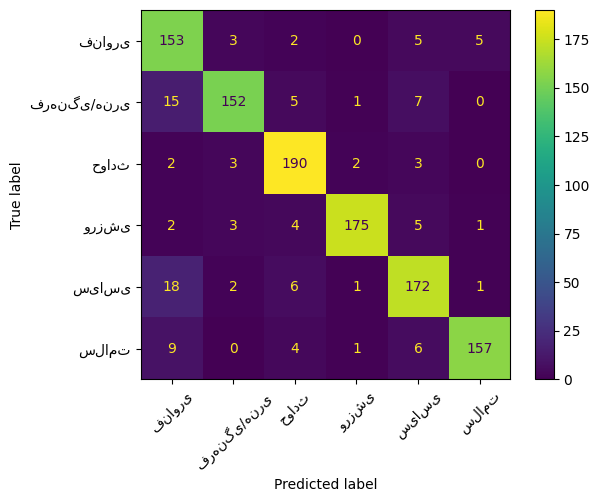

In [293]:
cf = confusion_matrix(test_['label'], test_[
                      'prediction'], labels=list(test_['label'].unique()))
r = ConfusionMatrixDisplay(
    confusion_matrix=cf,  display_labels=list(test_['label'].unique()))
print("Accuracy " + str(accuracy(test_['label'], test_['prediction'])))
print("Precision")
draw_dictionary(precision(test_)).show()
print("Recall")
draw_dictionary(recall(test_)).show()

recalls = pd.DataFrame(recall(test_), index=[0])
precisions = pd.DataFrame(precision(test_), index=[0])
F1 = ((recalls * precisions) * 2)/(recalls + precisions)
print("F1")
draw_dictionary(F1).show()
r.plot(xticks_rotation=45)


Macro Average

In [306]:
macro_Average = F1.mean(axis=1) 

macro_Average

0    0.895958
dtype: float64